# How to use the `carma_pack` to model (astrophysical) time series

* This tutorial is based on the notebook by B. C. Kelly included with the [`carma_pack package`](https://github.com/brandonckelly/carma_pack).


* The purpose of this notebook is to illustrate most of the functionality of `carma_pack` so that users can start applying it to their own data.


* Details can be found in [Kelly et al. 2014, ApJ, 788, 33](http://arxiv.org/abs/1402.5978).

# Outline

### A. Background

   1. [Definition of the CARMA process](#sectionA1)
   2. [Power spectral density of the CARMA process](#sectionA2)
   3. [Interpretation of the CARMA process](#sectionA3)
   4. [The likelihood function for the CARMA process](#sectionA4)

### B. Analysis of a Real Time Series

   1. [Running the MCMC Sampler](#sectionB1)
   2. [Assessing the appropriateness of a CARMA model](#sectionB2)
   3. [Plotting the inferred power spectrum](#sectionB3)
   4. [Working with the sampled parameter values](#sectionB4)

# A. Background

__`carma_pack` implements Bayesian inference for Gaussian continuous-time autoregressive moving average (CARMA) models via Markov Chain Monte Carlo (MCMC) sampling. CARMA models provide a flexible framework for modeling irregularly-sampled gappy time series.__

<a id="sectionA1"></a>
### __1. Definition of the CARMA process__

A zero-mean __CARMA process__ $y(t)$ of order $p, q$ is defined according to the __stochastic differential equation__: 

$$\frac{d^p y(t)}{dt^p} + \alpha_{p-1} \frac{d^{p-1} y(t)}{dt^{p-1}} + \ldots + \alpha_0 y(t) = \beta_q \frac{d^q \epsilon(t)}{dt^q} + \beta_{q-1} \frac{d^{q-1} \epsilon(t)}{dt^{q-1}} + \ldots + \epsilon(t).$$ 

In this equation:

+ $\epsilon(t)$ is a Gaussian white noise process with mean zero and variance $\sigma^2$,


+ $\alpha_0, ... , \alpha_p$ are the autoregressive (AR) coefficients,


+ $\beta_0, ..., \beta_q$ are the moving average (MA) coefficients,


+ $\alpha, \beta,$ and $\sigma^2$ are the free parameters of the model,


+ and we define $\alpha_p = 1$ and $\beta_0 = 1$.

***

A CARMA $(p, q)$ process is __stationary__ when

+ $q < p$, and


+ the roots $r_k$ of the autoregressive polynomial $A(z) = \sum_{k = 0}^p \alpha_k z^k$ have negative real parts.

***

A CARMA $(p, q)$ process is __Gaussian__ if the white noise term is Gaussian.

***

> __Note:__
>
> The case with $p=1$ and $q=0$ reduces to the well known __CAR(1) process__, or damped random walk, or Ornstein-Uhlenbeck process,
>
> $$\frac{dy(t)}{dt} + \alpha_0 y(t) = \epsilon (t),$$ for which the PSD and autocovariance are, respectively, $$P(f) = \sigma^2 \frac{1}{\alpha_0^2 + (2 \pi f)^2}$$ and $$R(\tau) = \frac{\sigma^2}{2\alpha_0} \exp(-\alpha_0 \tau).$$
>
> As can be seen, the PSD for the CAR(1) process is a Lorentzian function centered at zero with a break frequency at $\alpha_0/(2\pi)$, while the autocorrelation function, ACF, decays exponentially with an $e$-folding timescale $1/\alpha_0$.


### Simulation of a CAR(1) process

__Let's go ahead and use `carma_pack` to simulate a CAR(1) process irregularly-sampled over three seasons.__

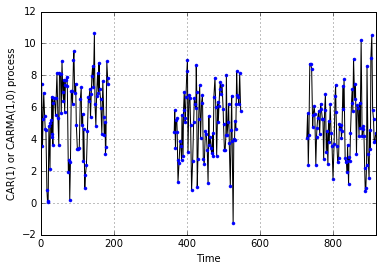

In [1]:
%matplotlib inline
import carmcmc as cm
import numpy as np
import matplotlib.pyplot as plt

ny = 270
t = np.zeros(ny)
dt = np.random.uniform(1.0, 3.0, ny)

t0 = 90

# season 1
t[0:90] = np.cumsum(dt[0:90])

# season 2, 180 time units between seasons
t[90:2*90] = 180 + t[90-1] + np.cumsum(dt[90:2*90])

# season 3
t[2*90:] = 180 + t[2*90-1] + np.cumsum(dt[2*90:])

mu = 5.
sigsqr = 4.
tau = 3.

# car1 process
y = mu + cm.carma_pack.car1_process(t, sigsqr, tau)

for i in range(3):
    plt.plot(t[90*i: 90*(i+1)], y[90*i: 90*(i+1)], 'k')
    plt.plot(t[90*i: 90*(i+1)], y[90*i: 90*(i+1)], 'b.')
    
plt.xlabel('Time')
plt.ylabel('CAR(1) or CARMA(1,0) process')
plt.grid()
plt.xlim(0, t.max());

__Let's plot the power spectrum of this CAR(1) process.__

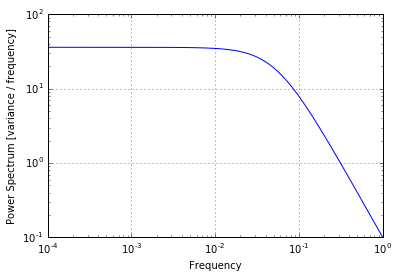

In [2]:
frequencies = np.logspace(-4.0, 0.0, 200)
pspec = sigsqr / ( (1/tau)**2 + (2 * np.pi * frequencies)**2)
plt.loglog(frequencies, pspec)
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum [variance / frequency]')
plt.grid();

<a id="sectionA2"></a>
### __2. Power spectral density of the CARMA process__

A stationary CARMA $(p, q)$ process has a __power spectral density__ (PSD) given by a ratio of polynomials,

$$ P(f)  = \sigma^2 \frac{\left| \sum_{j=0}^q \beta_j (2\pi i f)^j \right|^2}{\left| \sum_{k=0}^p \alpha_k (2\pi i f)^k \right|^2},$$

and an __autocovariance function__ (ACF) at lag $\tau$ given by

$$ R(\tau) = \sigma^2 \sum_{k=1}^p \frac{ \left[\sum_{l=0}^q \beta_l r_k^l \right] \left[\sum_{l=0}^q \beta_l (-r_k)^l \right] \exp(r_k \tau) }{ -2 \operatorname{Re}(r_k) \prod_{l=1, l \neq k}^p (r_l - r_k)(r^*_l + r_k) }.$$

<a id="sectionA3"></a>
### __3. Interpretation of the CARMA process__


### ACF

Insights from the inspection of the ACF of the CARMA $(p, q)$ process:

+ For the CARMA $(p, q)$ process the ACF is a weighted sum of exponential function.


+ The weights are a function of the MA coefficients, $\beta_l$.


+ The arguments of these exponential functions depend on the roots $r_k$ of the AR polynomial $A(z)$.


+ The roots $r_k$ might be complex-valued, although if $p$ is odd there is always at least one real root.


The ACF for the CARMA $(p, q)$ process is a sum of __exponentially damped sinusoidal functions__ (corresponding to the complex roots) and __exponential decays__ (corresponding to the real roots).

__The frequencies of the oscillations__ in the autocorrelations are $|{\rm Im}(r_k)|/2\pi$.

__The $e$-folding timescale__ of the decaying autocorrelations for each exponential function is $1/|{\rm Re}(r_k)|$.

***

### PSD

The PSD and the autocovariance function are a Fourier transform pair, so we can also connect the roots of $A(z)$
to the PSD.

The Fourier transform of an exponentially damped sinusoidal function is a Lorentzian function, so the PSD of a CARMA $(p, q)$ process can be expressed as __a weighted sum of Lorentzian functions__. As with the autocovariance function, the MA coefficients $\beta_l$ help control the weights in the sum.


__The centroids__ of the Lorentzian functions are given by $|{\rm Im}(r_k)/(2\pi)|$.


__The widths__ of the Lorentzian functions are $\propto |{\rm Re}(r_k)|$.

***

> __Note:__
>
> A sum of Lorentzian functions is a common model used to characterize the X-ray PSDs of X-ray binaries (e.g., Nowak 2000; Belloni 2010), and AGNs (e.g. McHardy et al. 2007).

### Simulation of a CARMA process

__Let's use `carma_pack` to simulate a CARMA(5,3) process__, plot the simulated lightcurve, and then compute and plot the power spectrum and autocorrelation function.

First let's set the parameter values. Because the power spectrum of a CARMA process can be expressed as a sum of Lorentzian functions, below we parameterize the CARMA model in terms of the parameters of these Lorentzian functions. This can be more intuitive than using the values of $\alpha$ directly.

In [3]:
# Set the CARMA model parameters

# dispersion in the time series
sigmay = 2.3  

# order of the AR polynomial
p = 5

# mean of the time series
mu = 17.0

# widths of of Lorentzian components
qpo_width = np.array([1.0/100.0, 1.0/300.0, 1.0/200.0])
# qpo_width = np.array([1.0/25.0, 1.0/300.0, 1.0/1000.0])

# centroids of Lorentzian components
qpo_cent = np.array([1.0/5.0, 1.0/25.0, 0.])
# qpo_cent = np.array([1.0/2.0, 1.0/10.0, 0.])

# Compute the roots r_k from the Lorentzian function parameters
ar_roots = cm.get_ar_roots(qpo_width, qpo_cent)

# Compute the AR and MA coefficients
ar_coefs = np.poly(ar_roots)
ma_coefs = np.array([1.0, 4.5, 1.25, 0.0, 0.0])
# ma_coefs = [1.0]

# Convert CARMA model variance to variance in the driving white noise
# (cm.carma_variance computes the autcovariance function)
sigsqr = sigmay ** 2 / cm.carma_variance(1.0, ar_roots, ma_coefs=ma_coefs)
y = mu + cm.carma_process(t, sigsqr, ar_roots, ma_coefs=ma_coefs)

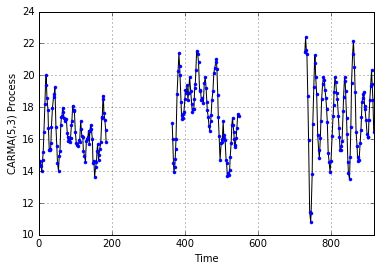

In [4]:
for i in range(3):
    plt.plot(t[90*i:90*(i+1)], y[90*i:90*(i+1)], 'k')
    plt.plot(t[90*i:90*(i+1)], y[90*i:90*(i+1)], 'b.')
    
plt.xlabel('Time')
plt.ylabel('CARMA(5,3) Process')
plt.xlim(0, t.max())
plt.grid();

__Let's plot the power spectrum of this CARMA process.__

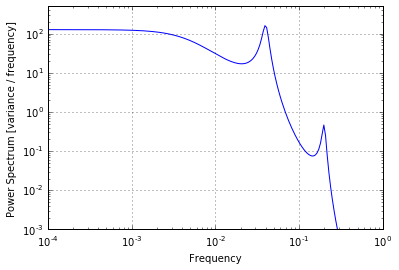

In [5]:
frequencies = np.logspace(-4.0, 0.0, 200)
pspec = cm.power_spectrum(frequencies, np.sqrt(sigsqr), ar_coefs, ma_coefs)

plt.loglog(frequencies, pspec)
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum [variance / frequency]')
plt.ylim(1e-3, 500)
plt.grid();

The two peaks in the power spectrum correspond to __quasi-periodic modes__ with centroids and widths given by the Lorentzian parameters of our CARMA(5, 3) model. Also note that the turnover to a flat power spectrum occurs at a frequency given by the third Lorentzian width parameter.

__Let's take a look at the autocorrelation function.__

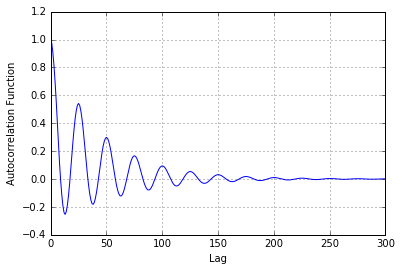

In [6]:
lag = np.linspace(0.0, 300.0, 300)
autocovar = cm.carma_variance(sigsqr, ar_roots, ma_coefs, lag)

# normalize by stationary variance
autocorr = autocovar / autocovar[0]

plt.plot(lag, autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Function')
plt.grid();

The autocorrelation function has the appearance of an exponentially damped sinusoid.

In reality, it is __a sum of two exponentially-damped sinusoids and one exponential decay__, with the damping time scales proportional to the widths of the Lorentzian functions. The oscillation frequencies of the two damped sinusoids are proportional to the centroids of the Lorentzian functions.

<a id="sectionA4"></a>
### 4. The likelihood function for the CARMA process

In the case of a Gaussian CARMA process, __a likelihood function__ may be derived for a measured time series $\mathbf{y} = [y_1, ..., y_n]^T$ sampled at times $t_1, ... , t_n$.


$$p(\mathbf{y}~|~\mu, \sigma, \alpha, \beta) \propto \frac{1}{|\Sigma|} \exp \left \{-\frac{1}{2}(\mathbf{y}-\mu)^T \Sigma^{-1}(y-\mu) \right \},$$

$$\Sigma_{ij} = R(|t_i - t_j|) + \delta_{ij}\sigma_i^2,$$

where $\mu$ is the mean of the time series, $\alpha = (\alpha_0, ..., \alpha_{p-1})$, $\beta = (\beta_1, ..., \beta_q)$, $\sigma_i^2$ is the variance in the measurement error for $y_i$, $\delta_{ij}$ is the delta function, and $R(.)$ is the autocovariance function of the CARMA $(p, q)$ process.

***

__Maximum-likelihood estimates__ of the parameters $\mu$, $\sigma$, $\alpha$, $\beta$ may be obtained by maximazing the likelihood function.

***

__Bayesian inference__ may be performed based on the posterior distribution $p(\theta~|~y)$ obtained by combining the likelihood function with a suitably chosen prior $p(\theta)$:

$$ p(\theta~|~y) \propto p(\theta)~p(y~|~\theta).$$

# B. Analysis of a Real Time Series

While plotting power spectra and time series generated from different CARMA processes is helpful for exploring the 'machinery' of the CARMA process, the primary purpose of `carma_pack` is to model real time series. Here it is illustrated how to do this using an astronomical time series of magnitudes (a measure of brightness) for a variable star from the *OGLE-III* variable star catalog. This time series is also contaminated by Gaussian measurement error.  Further details may be found in [our paper](http://arxiv.org/abs/1402.5978).

First let's load the data and plot the time series:

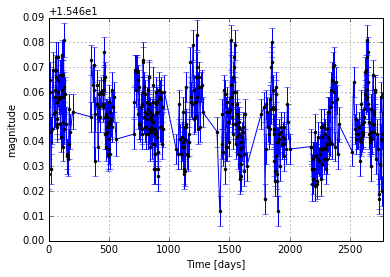

In [7]:
data = np.genfromtxt('OGLE-LMC-LPV-00007.dat')

# time is given by the julian date
juldate = data[:,0]

# set first time value to zero for convenience, units of t are days
t = juldate - juldate.min()

# i-band magnitudes
y = data[:,1]

# standard deviation in the measurement noise
yerr = data[:,2]

plt.errorbar(t, y, yerr=yerr)
plt.plot(t, y, 'k.')
plt.xlim(t.min(), t.max())
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.grid();

In [8]:
# Median time bin in days
np.median(t[1:] - t[:-1])

3.0891850000002705

<a id="sectionB1"></a>
### 1. Running the MCMC sampler

There are two classes in `carma_pack`:
  * `CarmaModel`
  * `CarmaSample`
  
The `CarmaModel` class defines a CARMA model, while the `CarmaSample` class is a sample of CARMA models generated by the MCMC sampler.

__First we need to create a CARMA model:__

The CARMA model order input is optional. The default is CAR(1) with p=1, q=0. If we want to automatically choose the CARMA order by minimizing the AICc we can use the `CarmaModel.choose_order` method to do this.

Because this can take a long time for larger pmax, here we simply set the order to $(p,q)=(6,0)$ as this is what was found in our paper for this lightcurve from minimizing the AICc (Akaike information criterion).

In [9]:
# CARMA(6, 0)
carma_model = cm.CarmaModel(t, y, yerr, p=6, q=0)

In [10]:
# %%capture capt
# pmax = 6
# MLE, pqlist, AICc_list = carma_model.choose_order(pmax, njobs=-1)

Now that we have a `CarmaModel` object, let's run the MCMC sampler. We will generate 20,000 samples of the CARMA parameters from their probability distribution given the measured time series (this is called the __'posterior distribution'__). We can also specify the number of burn-in iterations to perform, the number of chains to use in the parallel tempering algorithm, and the number of iterations to thin. Here we just use the default values.

Running the MCMC sampler will probably take about 10-15 minutes.

In [11]:
# %%capture capt
# sample = carma_model.run_mcmc(20000)

In [12]:
import cPickle
# cPickle.dump(sample, open('sample.pickle', 'wb')) # dump the sample
sample = cPickle.load(open('sample.pickle', 'rb')) # load the sample

<a id="sectionB2"></a>
### 2. Assessing the appropriateness of a CARMA Model

Before using our samples, let's first make sure the CARMA model provides an adequate description of the time series.

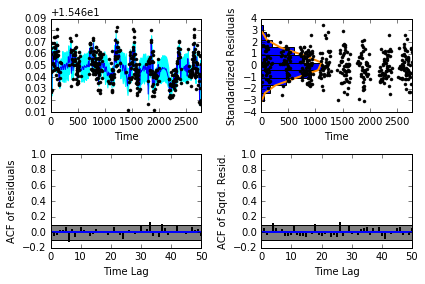

In [13]:
sample.assess_fit()

This routine generated __four panels__ that we can use to assess the quality of the fit.

* __The upper left panel__ compares the data with the interpolated CARMA model and it's standard error based on the parameters that had the highest posterior probability.


* __The upper right panel__ compares the residuals. If the assumption of a Gaussian CARMA process is adequate the residuals should be uncorrelated and have a standard normal distribution (shown by the orange line).


* __The two lower panels__ show the autocorrelation function of the residuals and their square, along with the 95% confidence intervals for white noise.

Everything seems to check out: we can see that there is no strong reason to reject the Gaussian CARMA process as providing an adequate model for this time series.  

<a id="sectionB3"></a>
### 3. Plotting the inferred power spectrum

Now let's see what the power spectrum looks like:

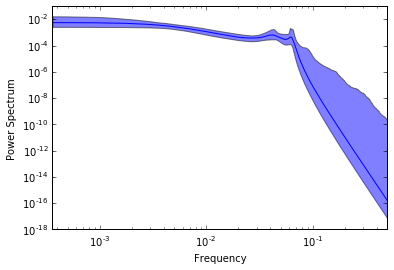

In [14]:
psd_low, psd_hi, psd_mid, frequencies = sample.plot_power_spectrum(percentile=95.0, nsamples=5000)

__Here we have plotted the regions containing 95% of the posterior probability of the power spectrum as a function of frequency.__ The routine `CarmaSample.plot_power_spectrum` returns a tuple containing the lower bound on the power spectrum, the upper bound, the posterior median, and the frequencies used. Here we tell the routine to only use 5000 samples when computing the power spectrum bounds to increase the speed.

It can be helpful to get a sense of where the __measurement noise level__ is on the power spectrum. We can estimate this as $2 \bar{\Delta t} \bar{\sigma_y^2}$, where $\bar{\Delta t}$ and $\bar{\sigma^2_y}$ are the average time spacing and measurement noise variance, respectively. The median may also be used and may be preferable in certain cases. Because there is no point in interpreting the power spectrum too far below the measurement noise level, we reset the vertical plot limits to focus on the regions not dominated by measurement noise.

In [15]:
dt = t[1:] - t[:-1]
noise_level = 2.0 * np.mean(dt) * np.mean(yerr**2)

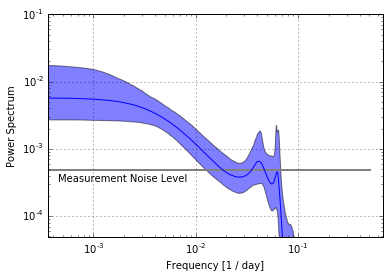

In [16]:
plt.loglog(frequencies, np.ones(frequencies.size) * noise_level, color='grey', lw=2)
plt.loglog(frequencies, psd_mid)
plt.fill_between(frequencies, psd_hi, y2=psd_low, alpha=0.5)
plt.ylim(noise_level / 10.0, plt.ylim()[1])
plt.xlim(frequencies.min(), frequencies[psd_hi > noise_level].max() * 10.0)
plt.ylabel('Power Spectrum')
plt.xlabel('Frequency [1 / day]')
plt.annotate("Measurement Noise Level", (1.25 * plt.xlim()[0], noise_level / 1.5))
plt.grid();

<a id="sectionB4"></a>
### 4. Working with the sampled parameter values

Finally, in many cases we will want to access the MCMC samples for the CARMA parameters. The list of parameter names are stored as a member of the `CarmaSample` object:

In [17]:
sample.parameters

['quad_coefs',
 'logpost',
 'ar_coefs',
 'mu',
 'psd_centroid',
 'loglik',
 'psd_width',
 'var',
 'measerr_scale',
 'sigma',
 'ma_coefs',
 'ar_roots']

__The parameters are:__

| Parameter | Description |
|-------------------|
| logpost | The logarithm of the posterior probability distribution |
| loglik  | The logarithm of the likelihood function |
| mu      | The mean of the CARMA model |
| sigma   | The standard deviation in the driving white noise |
| ar_coefs | The coefficients for the autoregressive polynomial, $\alpha$ |
| ma_coefs | The coefficients of the moving average polynomial, $\beta$ |
| ar_roots | The roots of the autoregressive polynomial, $r_k$ |
| psd_centroid | The centroid frequencies of the Lorentzian functions, under the sum-of-Lorentzians interpretation of the power spectrum |
| psd_width | The widths of the Lorentzian functions |
| measerr_scale | A multiplicative scaling parameter that is multiplied to the supplied measurement noise variances, constrained to lie between 0.5 and 2. The true measurement noise variances are assumed to be $A\sigma^2_y$, where $A$ is the scaling parameter |
| quad_coefs | This is the parameterization of the autoregressive parameters used in the MCMC sampler. These will almost never be of interest |

We can get the __sampled values__ using the `CarmaSample.get_samples` method. For example:

In [18]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 6)

We can also get a useful __summary of the parameter's posterior:__

In [19]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 441.0488387198264
Median: 0.06476949801609887
Standard deviation: 0.15894013798867607
68% credibility interval: [0.06232892 0.1527506 ]
95% credibility interval: [0.06062315 0.67961822]
99% credibility interval: [0.0588039  0.93792158]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 441.0488387198264
Median: 0.06476949801609887
Standard deviation: 0.15894013798867607
68% credibility interval: [0.06232892 0.1527506 ]
95% credibility interval: [0.06062315 0.67961822]
99% credibility interval: [0.0588039  0.93792158]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 331.7774892056844
Median: 0.04280292825780758
Standard d

We can __plot the trace of a parameter__ (value of the parameter as a function of MCMC iteration), a __histogram of its values__, and the __autocorrelation function of the MCMC samples.__ For example, to plot these quantities for the width of the fifth Lorentzian function:

Plotting parameter summary


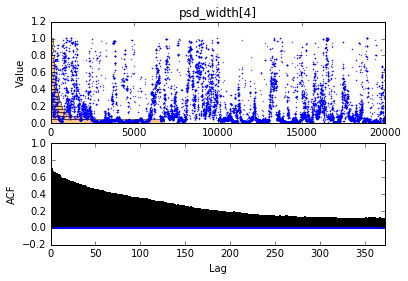

In [20]:
sample.plot_parameter('psd_width', 4, doShow=True)

Finally, we can make nice __plots of the estimated joint posterior distributions of pairs of parameters__ using `CarmaSample.plot2dkde`. For example, to plot the joint distribution of the time series mean and measurement error scale parameter we would do

Plotting 2d PDF w KDE


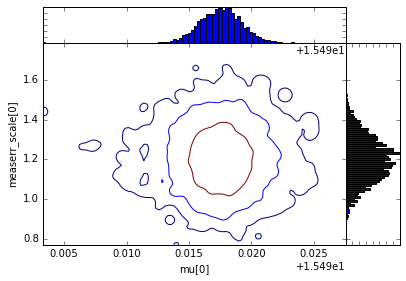

In [23]:
sample.plot_2dkde('mu', 'measerr_scale', doShow=True)

Similarly, we could do

Plotting 2d PDF


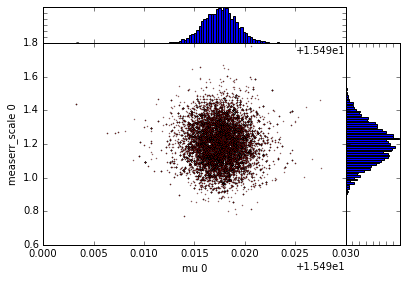

In [22]:
sample.plot_2dpdf('mu', 'measerr_scale', doShow=True)

***

# Conclusions

+ CARMA models have a very flexible parametric form for their power spectrum and autocorrelation function, and because of this they are able to model a broad range of non-deterministic time series. CARMA models therefore provide a flexible framework for analyzing irregularly sampled time series when some degree of stochasticity is expected.


+ Moreover, they also have the additional advantage that many of the computations involved with fitting, interpolating, and forecasting can be efficiently performed using the Kalman Filter.


+ And finally, Gaussian measurement noise is naturally incorporated into the analysis.

__The use of Bayesian inference is important for these models!__

***

## That's it! Enjoy using `carma_pack` on your own data.